In [1]:
!pip install torch

In [2]:
!pip install sentence_transformers

In [142]:
import json
import torch
from torch import nn
import numpy as np
from sentence_transformers import SentenceTransformer, models

In [2]:
# Load training dataset
f = open('conala-corpus/conala-train.json')
data = json.load(f)

In [6]:
import ast
import python_ast_utils
import ast2vec

ast2vec_model = ast2vec.load_model()

In [7]:
# Processes raw input data
def process_data(data):
    new_data = dict()
    for d in data:
        if d["question_id"] not in new_data.keys():
            new_data[d["question_id"]] = {"anchor": "", "pos": [], "neg":[], "pos_tree":[], "neg_tree": []}
        new_data[d["question_id"]]["anchor"] = d["intent"]
        new_data[d["question_id"]]["pos"].append("<s> " + str(d["rewritten_intent"]) + " </s> " + str(d["snippet"]) + " </s>")
        new_data[d["question_id"]]["pos_tree"].append(python_ast_utils.ast_to_tree(ast.parse(d["snippet"])))
    return new_data         
        

In [8]:
# Samples Negative Examples for Training
import random
def get_neg(id, new_data, num):
    neg_list = []
    tree_list = []
    for k in new_data.keys():
        if k != id:
            neg_list += new_data[k]["pos"]
            tree_list += new_data[k]["pos_tree"]
    indices = random.sample(range(len(neg_list)), num)
    new_data[id]["neg"] = [neg_list[i] for i in indices]
    new_data[id]["neg_tree"] = [tree_list[i] for i in indices]
    

In [9]:
# Processes Data
new_data = process_data(data)

In [25]:
# Required Constants and Hyperparameters
max_seq_len = 256
output_vector_len = 256
NUM_EPOCHS = 100
NUM_SAMPLES = 1024
lmbda = 0.5
temperature = 0.02

In [14]:
# Create Transformer and Dense Layers for BERT model for code snippets and queries respectively

code_word_embedding_model = models.Transformer("microsoft/codebert-base", max_seq_length=max_seq_len)
query_word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=max_seq_len)


code_pooling_model = models.Pooling(code_word_embedding_model.get_word_embedding_dimension())
code_dense_model = models.Dense(in_features=code_pooling_model.get_sentence_embedding_dimension(), out_features=output_vector_len, activation_function=nn.Tanh())

query_pooling_model = models.Pooling(query_word_embedding_model.get_word_embedding_dimension())
query_dense_model = models.Dense(in_features=query_pooling_model.get_sentence_embedding_dimension(), out_features=output_vector_len, activation_function=nn.Tanh())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [143]:
# Make dense layer trainable
for param in query_dense_model.parameters():
    param.requires_grad = True
    
for param in code_dense_model.parameters():
    param.requires_grad = True

In [18]:
# Final Sentence Transformer Models for Code and Query
code_bert_model = SentenceTransformer(modules=[code_word_embedding_model, code_pooling_model, code_dense_model])
query_bert_model = SentenceTransformer(modules=[query_word_embedding_model, query_pooling_model, query_dense_model])

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
# Defining respective optimizers for code and query
opt_code = torch.optim.Adam(code_bert_model.parameters(), lr=0.0001)
opt_query = torch.optim.Adam(query_bert_model.parameters(), lr=0.0001)

In [21]:
# Contrastive Loss Funciton for Training

def contrastive_loss(joint_pos, joint_neg, anchor_out, temperature=0.01):
    
    pos_size = joint_pos.shape[0]
    num_pos = nn.functional.cosine_similarity(anchor_out, joint_pos)/temperature
    num_neg = nn.functional.cosine_similarity(anchor_out, joint_neg)/temperature

    num_pos_neg = torch.cat((num_pos,num_neg))
    num_pos_neg = nn.functional.softmax(num_pos_neg)
    loss = torch.sum(num_pos_neg[:pos_size])/torch.sum(num_pos_neg)
    loss = torch.tensor(-torch.log(loss), requires_grad=True)
    
    return loss

In [32]:
training_losses = []
def fit(code_bert_model, query_bert_model, tree_encoder, train_data, opt_code, opt_query, epochs=10, num_samples=32, lmbda=0.5):
    for epoch in range(epochs):
        epoch_loss = 0.0
        indices = random.sample(train_data.keys(), num_samples)
        print("-"*25, f"Epoch {epoch+1}","-"*25)
        for i in indices:
            qid = i
            data = train_data[qid]
            
            get_neg(qid, train_data, len(data["pos"]) * 3)
            
            pos_out = torch.stack([code_bert_model.encode(pos, convert_to_tensor=True) for pos in data["pos"]])
            neg_out = torch.stack([code_bert_model.encode(neg, convert_to_tensor=True) for neg in data["neg"]])
            
            pos_tree_out = torch.stack([tree_encoder.encode(pos_tree) for pos_tree in data["pos_tree"]])
            neg_tree_out = torch.stack([tree_encoder.encode(neg_tree) for neg_tree in data["neg_tree"]])
            
            assert(len(pos_out) == len(pos_tree_out))
            assert(len(neg_out) == len(neg_tree_out))
            
            joint_pos = lmbda*pos_out + (1-lmbda)*pos_tree_out
            joint_neg = lmbda*neg_out + (1-lmbda)*neg_tree_out                   
             
            anchor_out = query_bert_model.encode(data["anchor"], convert_to_tensor=True)
            anchor_out = torch.unsqueeze(anchor_out,0)
            loss = contrastive_loss(joint_pos, joint_neg, anchor_out, temperature=temperature)
            
            epoch_loss += loss
            
            loss.backward()
            opt_code.step()
            opt_query.step()
            opt_code.zero_grad()
            opt_query.zero_grad()
        
        epoch_loss /= num_samples 
        training_losses.append(epoch_loss.item())
        print(f"Training loss: {epoch_loss:.4f}")
            

In [ ]:
# Training the Model
fit(code_bert_model, query_bert_model, ast2vec_model, new_data, opt_code, opt_query, epochs=NUM_EPOCHS, num_samples=NUM_SAMPLES, lmbda=lmbda)

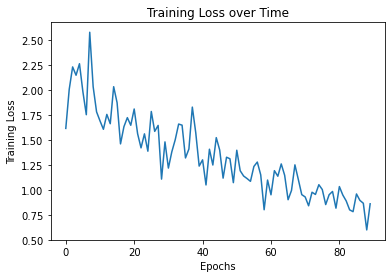

In [74]:
# Plot the Training Loss over Epochs
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title("Training Loss over Time")
plt.show()

Testing

In [95]:
# Load test data
f = open('conala-corpus/conala-test.json')
data = json.load(f)

In [96]:
# Process test data
new_data = process_data(data)

In [97]:
# Get Tree Embeddings of Code Snippets
trees = [python_ast_utils.ast_to_tree(ast.parse(d["snippet"])) for d in data]
tree_embeddings = torch.stack([ast2vec_model.encode(tree) for tree in trees])

In [98]:
# Get Code Text Embeddings for Code Snippets with Description
code_text = ["<s> "+str(d["rewritten_intent"]) + " </s> " + str(d["snippet"]) + " </s>" for d in data]
code_text_embeddings = torch.stack([code_bert_model.encode(t, convert_to_tensor=True) for t in code_text])

In [105]:
# Get joint embedding combining code-text embedding and tree embedding
joint_embeddings = lmbda*code_text_embeddings + (1-lmbda)*tree_embeddings 

In [127]:
# Get query ids list
ids = [d["question_id"] for d in data]

In [133]:
# Get indices belonging to top hits
def top_hits(query, k=3):
    query_embedding = query_bert_model.encode(query, convert_to_tensor=True)
    similarities = nn.functional.cosine_similarity(query_embedding, joint_embeddings)
    sorted, indices = torch.sort(similarities, descending=True)
    # print(indices[:k])
    return indices[:k].tolist()

In [134]:
# Get code snippets corresponding to top hits
def search(query, k=3):
    indices = top_hits(query, k)
    code_snippets = [data[i]["snippet"] for i in indices]
    return code_snippets

In [ ]:
indices = top_hits("How to convert a string list into an integer in python")
print([ids[i] for i in indices])

In [139]:
# Get recall for query at index idx
def get_recall(idx, k=3):
    query = data[idx]["intent"]
    indices = top_hits(query, k)
    query_ids = [ids[i] for i in indices]
    query_id = ids[idx]
    return sum([query_id==i for i in query_ids])/k

In [ ]:
# Get average recall
recalls = []
for i in range(500):
    recalls.append(get_recall(i))

print(sum(recalls)/500)